Problem statement: Forecast the next day’s average temperature using the multivariate weather history from Kaggle. Here we build a feed-forward neural network (MLP/FFNN) that treats each day’s weather across all cities as a single feature vector and predicts tomorrow’s temperature.

Significance: A simple FFNN provides a fast, low-complexity baseline for short-term weather forecasting. Comparing its performance to the LSTM model highlights how much benefit we gain from explicitly modeling temporal structure, and whether a non-sequence neural network is already sufficient for practical planning.


In [ ]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf

In [ ]:
# Load the weather dataset
df = pd.read_csv("weather_prediction_dataset.csv")

print("Shape:", df.shape)
print("First 10 columns:", df.columns[:10].tolist())
df.head()

Shape: (3654, 165)
First 10 columns: ['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_humidity', 'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation', 'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min']


,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


In [ ]:
#Data preperation function
def prepare_ffnn_data(df, target_col, date_col="DATE", test_size=0.2):
    """
    Prepares features and target for a feed forward NN regression model.
    - df: original dataframe
    - target_col: name of the temperature column to predict
    - date_col: name of the date column
    - test_size: fraction of data for test set (time based)
    """
    work = df.copy()

    # Parse date and sort chronologically
    if date_col in work.columns:
        work[date_col] = pd.to_datetime(work[date_col], format="%Y%m%d", errors="coerce")
        work = work.dropna(subset=[date_col])
        work = work.sort_values(date_col)
        date_index = work[date_col].reset_index(drop=True)
    else:
        date_index = pd.RangeIndex(len(work))

    # Ensure target is numeric
    work[target_col] = pd.to_numeric(work[target_col], errors="coerce")

    # Handle missing values
    numeric_cols = work.select_dtypes(include=[np.number]).columns
    cat_cols = work.select_dtypes(include=["object", "category", "bool"]).columns

    # Interpolate numeric and fill any leftover with median
    work[numeric_cols] = work[numeric_cols].interpolate(limit_direction="both")
    work[numeric_cols] = work[numeric_cols].fillna(work[numeric_cols].median())

    # Mode imputation for categoricals
    for col in cat_cols:
        work[col] = work[col].fillna(work[col].mode().iloc[0])

    # Drop date from features but keep a copy for plotting
    model_df = work.copy()
    if date_col in model_df.columns:
        model_df = model_df.drop(columns=[date_col])

    # One hot encode any categorical features (there probably are none here)
    model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=True)

    # Drop any remaining rows with missing target
    model_df = model_df.dropna(subset=[target_col])

    # Separate features and target
    y = model_df[target_col].values.astype("float32")
    X = model_df.drop(columns=[target_col]).values.astype("float32")

    # Time based train test split (no shuffling)
    n = len(X)
    split_idx = int(n * (1 - test_size))

    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    date_train, date_test = date_index.iloc[:split_idx], date_index.iloc[split_idx:]

    # Scale features and target separately
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

    print(f"Target: {target_col}")
    print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
    print(f"Number of features: {X_train.shape[1]}")

    return {
        "X_train_scaled": X_train_scaled,
        "X_test_scaled": X_test_scaled,
        "y_train_scaled": y_train_scaled,
        "y_test_scaled": y_test_scaled,
        "y_train": y_train,
        "y_test": y_test,
        "date_train": date_train,
        "date_test": date_test,
        "feature_scaler": feature_scaler,
        "target_scaler": target_scaler,
    }


In [ ]:
#Build FFNN
def build_ffnn(input_dim):
    """
    Simple feed forward neural network for regression.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)  # regression output
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model


In [ ]:
#Plot FFNN result function
def plot_target_eda(df, target_col, date_col="DATE"):
    """
    Plot distribution and time series of a target variable.
    """
    plt.figure(figsize=(10, 4))
    sns.histplot(df[target_col], bins=30, kde=True, color="coral")
    plt.title(f"Distribution of target: {target_col}")
    plt.xlabel(target_col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    if date_col in df.columns:
        date_vals = pd.to_datetime(df[date_col], format="%Y%m%d", errors="coerce")
        plt.plot(date_vals, df[target_col], label=target_col)
        plt.xlabel("Date")
    else:
        plt.plot(df[target_col].reset_index(drop=True), label=target_col)
        plt.xlabel("Observation index")
    plt.ylabel(target_col)
    plt.title(f"{target_col} over time")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_training_history(history):
    history_df = pd.DataFrame(history.history)
    plt.figure(figsize=(8, 4))
    plt.plot(history_df["loss"], label="loss")
    plt.plot(history_df["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Training history (FFNN)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_predictions(date_test, y_true, y_pred, target_col):
    # Time series
    plt.figure(figsize=(12, 4))
    plt.plot(date_test, y_true, label="Actual", color="black")
    plt.plot(date_test, y_pred, label="Predicted", color="teal")
    plt.title(f"Actual vs predicted {target_col}")
    plt.xlabel("Date")
    plt.ylabel(target_col)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Scatter
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Predicted vs Actual ({target_col})")
    plt.tight_layout()
    plt.show()


In [ ]:
#Funs FFNN for different target columns
def run_ffnn_for_target(df, target_col, date_col="DATE"):
    print("=" * 80)
    print(f"Running FFNN regression for target: {target_col}")
    print("=" * 80)

    # Basic EDA plots
    plot_target_eda(df, target_col, date_col=date_col)

    # Prepare data
    data = prepare_ffnn_data(df, target_col, date_col=date_col, test_size=0.2)

    X_train_scaled = data["X_train_scaled"]
    X_test_scaled = data["X_test_scaled"]
    y_train_scaled = data["y_train_scaled"]
    y_test_scaled = data["y_test_scaled"]
    y_train = data["y_train"]
    y_test = data["y_test"]
    date_test = data["date_test"]
    target_scaler = data["target_scaler"]

    # Build model
    model = build_ffnn(X_train_scaled.shape[1])
    model.summary()

    # Early stopping
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        )
    ]

    # Train
    history = model.fit(
        X_train_scaled,
        y_train_scaled,
        validation_split=0.2,
        epochs=20,
        batch_size=32,
        shuffle=False,  # keep temporal order for validation split
        callbacks=callbacks,
        verbose=1
    )

    # Plot training history
    plot_training_history(history)

    # Predict on test set and invert scaling
    y_pred_scaled = model.predict(X_test_scaled).flatten()
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Results for {target_col}:")
    print(f"  MAE  = {mae:.3f}")
    print(f"  RMSE = {rmse:.3f}")
    print(f"  R^2  = {r2:.4f}")

    # Plots of predictions
    plot_predictions(date_test, y_test, y_pred, target_col)

    return {
        "model": model,
        "history": history,
        "metrics": {"MAE": mae, "RMSE": rmse, "R2": r2},
        "y_test": y_test,
        "y_pred": y_pred,
        "date_test": date_test,
    }


Running FFNN regression for target: BASEL_temp_mean


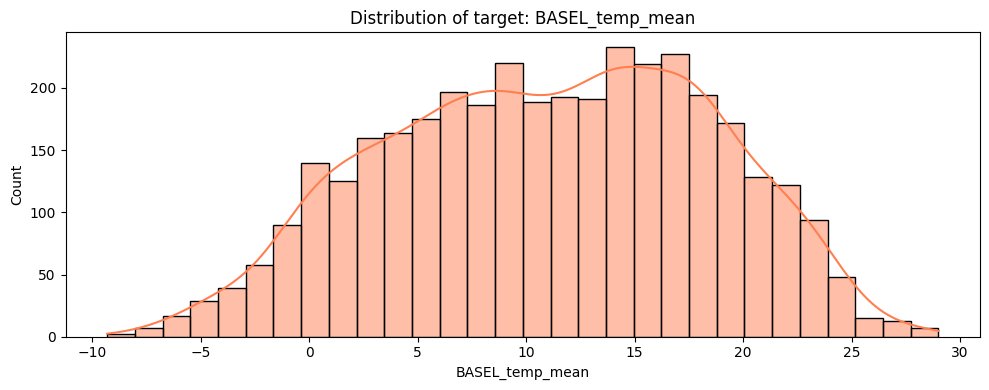

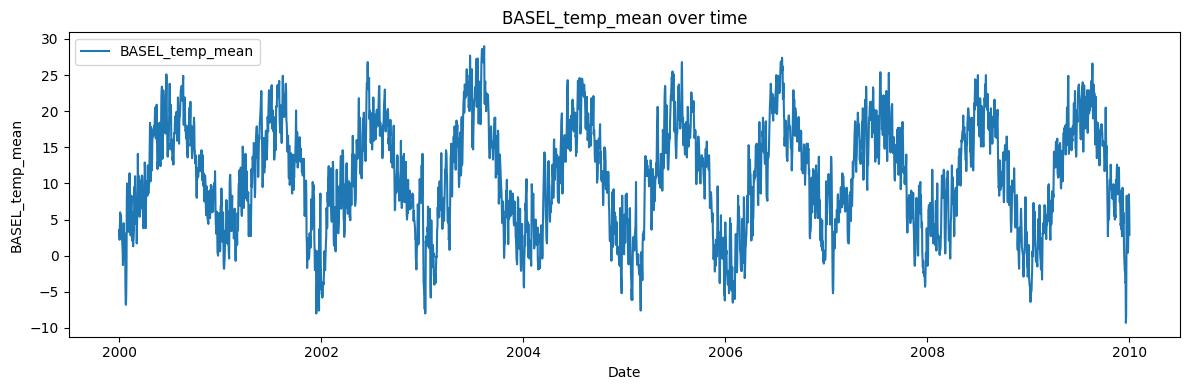

Target: BASEL_temp_mean
Train size: 2923, Test size: 731
Number of features: 163


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,313 (114.50 KB)

 Trainable params: 29,313 (114.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.1247 - mae: 0.7995 - val_loss: 0.1161 - val_mae: 0.2700
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1454 - mae: 0.2987 - val_loss: 0.0685 - val_mae: 0.2078
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0957 - mae: 0.2420 - val_loss: 0.0587 - val_mae: 0.1931
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0762 - mae: 0.2175 - val_loss: 0.0573 - val_mae: 0.1916
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0658 - mae: 0.2027 - val_loss: 0.0478 - val_mae: 0.1729
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0636 - mae: 0.1999 - val_loss: 0.0458 - val_mae: 0.1715
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0513 - mae: 0.1787 - val_loss: 0.0694 - val_mae: 0.2116
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0601 - mae: 0.1935 - val_loss: 0.0464 - val_mae: 0.1695
Epoch 9/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0666 - 

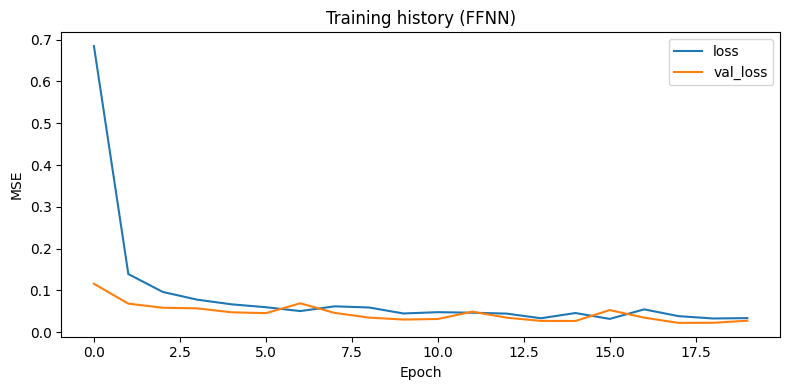

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Results for BASEL_temp_mean:
  MAE  = 0.827
  RMSE = 1.132
  R^2  = 0.9763


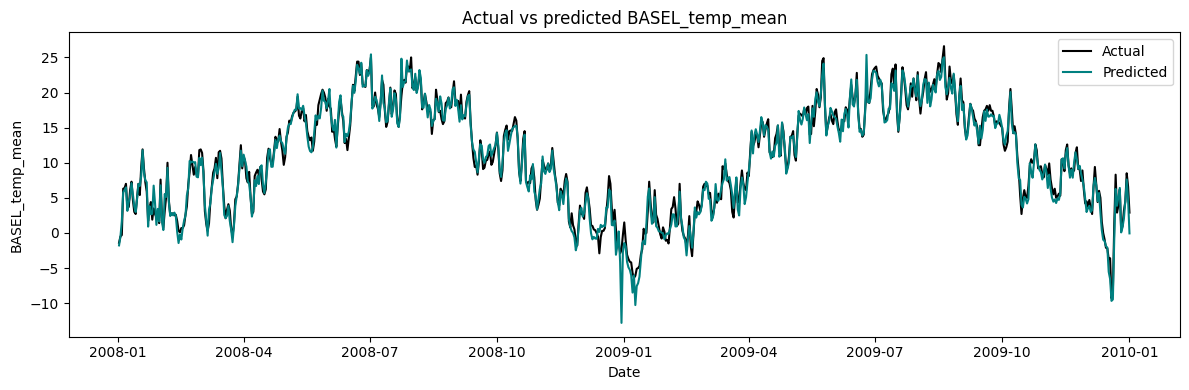

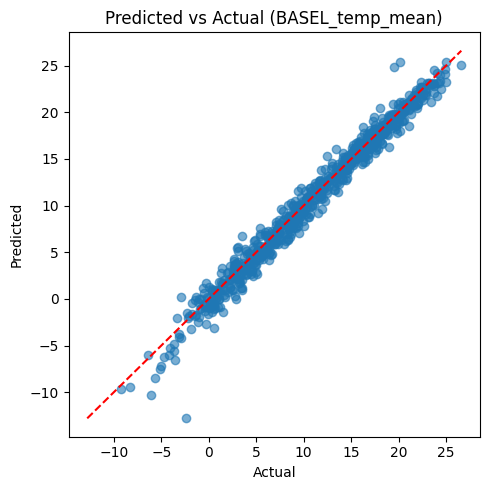

Running FFNN regression for target: ROMA_temp_mean


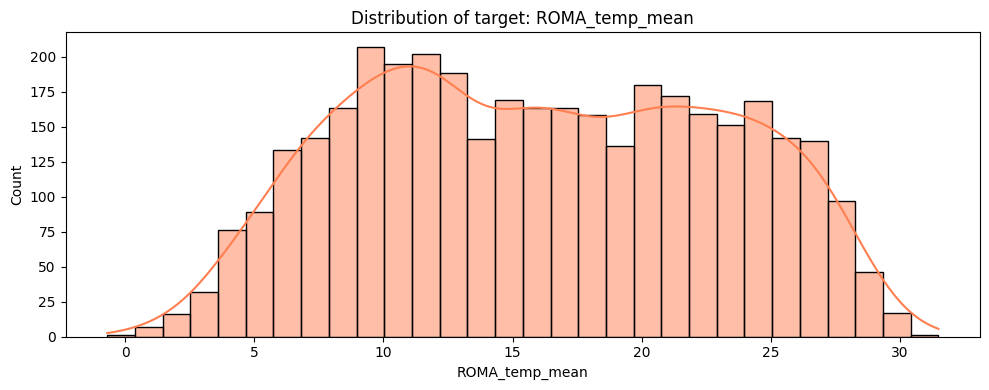

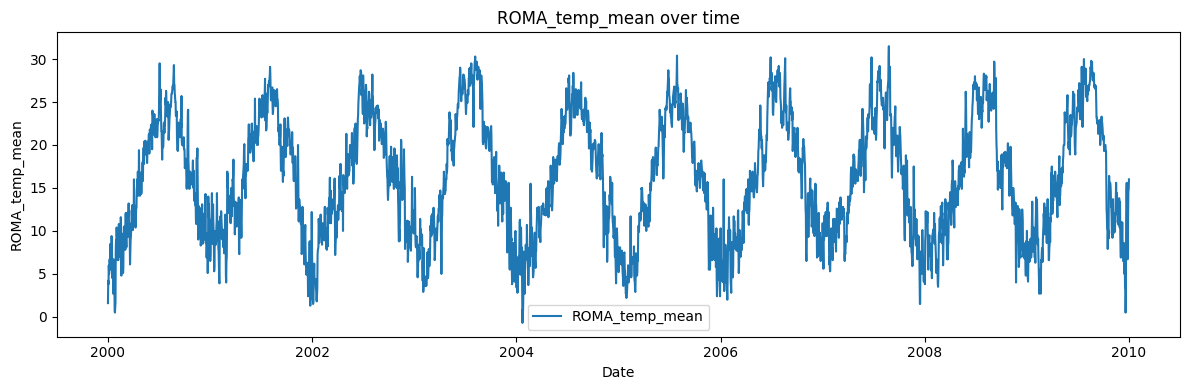

Target: ROMA_temp_mean
Train size: 2923, Test size: 731
Number of features: 163


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,313 (114.50 KB)

 Trainable params: 29,313 (114.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7861 - mae: 0.9069 - val_loss: 0.1798 - val_mae: 0.3385
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1696 - mae: 0.3228 - val_loss: 0.1189 - val_mae: 0.2730
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1318 - mae: 0.2882 - val_loss: 0.0958 - val_mae: 0.2422
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1094 - mae: 0.2576 - val_loss: 0.0810 - val_mae: 0.2239
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0868 - mae: 0.2314 - val_loss: 0.0699 - val_mae: 0.2078
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0845 - mae: 0.2274 - val_loss: 0.0702 - val_mae: 0.2088
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0718 - mae: 0.2110 - val_loss: 0.0859 - val_mae: 0.2286
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0757 - mae: 0.2153 - val_loss: 0.0624 - val_mae: 0.1955
Epoch 9/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0749 - mae: 

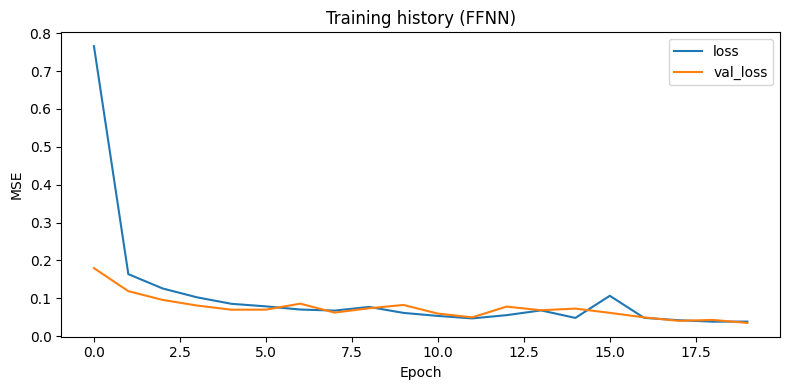

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Results for ROMA_temp_mean:
  MAE  = 1.124
  RMSE = 1.412
  R^2  = 0.9598


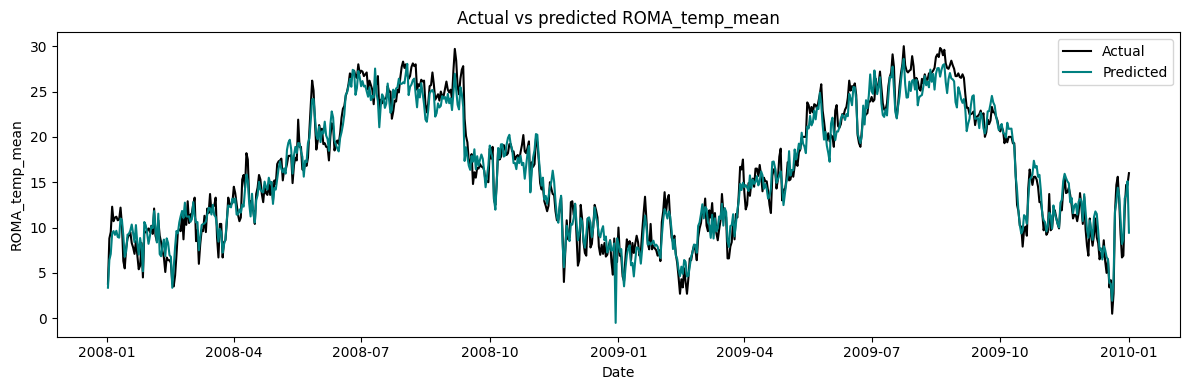

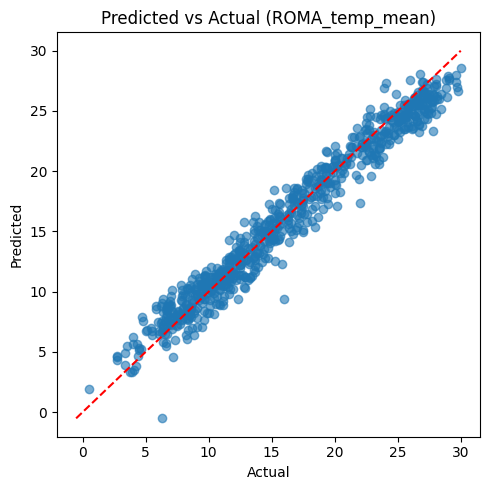

In [ ]:
# First FFNN model: Basel average temperature
results_basel = run_ffnn_for_target(df, target_col="BASEL_temp_mean", date_col="DATE")

# Second FFNN model: Rome average temperature
results_roma = run_ffnn_for_target(df, target_col="ROMA_temp_mean", date_col="DATE")

Now we will analyze the FFNN performance when the goal is to predict the NEXT day's temperature instead of the current day's temperature.

Purpose: Show the weakness of FFNN and why it's not the most optimal as a predictor, and why the LSTM is better in that case.

In [9]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf

sns.set_theme(style="whitegrid")

# Load the weather dataset
df = pd.read_csv("weather_prediction_dataset.csv")

print("Shape:", df.shape)
print("First 10 columns:", df.columns[:10].tolist())
df.head()

Shape: (3654, 165)
First 10 columns: ['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_humidity', 'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation', 'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min']


,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


In [10]:
def plot_target_eda(df, target_col, date_col="DATE"):
    """
    Plot distribution and time series of a target variable (same day, for context).
    """
    plt.figure(figsize=(10, 4))
    sns.histplot(df[target_col], bins=30, kde=True, color="coral")
    plt.title(f"Distribution of target: {target_col}")
    plt.xlabel(target_col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    if date_col in df.columns:
        date_vals = pd.to_datetime(df[date_col], format="%Y%m%d", errors="coerce")
        plt.plot(date_vals, df[target_col], label=target_col)
        plt.xlabel("Date")
    else:
        plt.plot(df[target_col].reset_index(drop=True), label=target_col)
        plt.xlabel("Observation index")
    plt.ylabel(target_col)
    plt.title(f"{target_col} over time")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [21]:
def prepare_ffnn_data_horizon(df, target_col, horizon_days=2, date_col="DATE", test_size=0.2):
    """
    Prepares features and target for an FFNN that predicts temperature H days ahead.

    For each day t:
      features = all weather features on day t
      target   = target_col on day t + horizon_days

    horizon_days: how many days into the future you want to predict (e.g., 7).
    The split is time based: first part train, last part test.
    """
    work = df.copy()

    # Parse date and sort chronologically
    if date_col in work.columns:
        work[date_col] = pd.to_datetime(work[date_col], format="%Y%m%d", errors="coerce")
        work = work.dropna(subset=[date_col])
        work = work.sort_values(date_col)
    else:
        work = work.sort_index()

    # Ensure target is numeric
    work[target_col] = pd.to_numeric(work[target_col], errors="coerce")

    # Create H-day-ahead target
    # TARGET_TPLUSH at row t = target_col at row t + horizon_days
    work["TARGET_TPLUSH"] = work[target_col].shift(-horizon_days)

    # Drop the last H rows where future target is missing
    work = work.dropna(subset=["TARGET_TPLUSH"]).reset_index(drop=True)

    # After drop, rebuild date index
    if date_col in work.columns:
        date_index = work[date_col].reset_index(drop=True)
    else:
        date_index = pd.RangeIndex(len(work))

    # Handle missing values
    numeric_cols = work.select_dtypes(include=[np.number]).columns
    cat_cols = work.select_dtypes(include=["object", "category", "bool"]).columns

    # Interpolate numeric and fill any leftover with median
    work[numeric_cols] = work[numeric_cols].interpolate(limit_direction="both")
    work[numeric_cols] = work[numeric_cols].fillna(work[numeric_cols].median())

    # Mode imputation for categoricals
    for col in cat_cols:
        work[col] = work[col].fillna(work[col].mode().iloc[0])

    # Build model frame: drop date column from features
    model_df = work.copy()
    if date_col in model_df.columns:
        model_df = model_df.drop(columns=[date_col])

    # One hot encode any categorical features
    model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=True)

    # Drop any remaining rows with missing H-day target
    model_df = model_df.dropna(subset=["TARGET_TPLUSH"])

    # Separate features and target (H-day ahead)
    y = model_df["TARGET_TPLUSH"].values.astype("float32")
    X = model_df.drop(columns=["TARGET_TPLUSH"]).values.astype("float32")

    # Time based train test split
    n = len(X)
    split_idx = int(n * (1 - test_size))

    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    date_train, date_test = date_index.iloc[:split_idx], date_index.iloc[split_idx:]

    # Scale features and target separately
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

    print(f"Target (t + {horizon_days} days of): {target_col}")
    print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
    print(f"Number of features: {X_train.shape[1]}")

    return {
        "X_train_scaled": X_train_scaled,
        "X_test_scaled": X_test_scaled,
        "y_train_scaled": y_train_scaled,
        "y_test_scaled": y_test_scaled,
        "y_train": y_train,
        "y_test": y_test,
        "date_train": date_train,
        "date_test": date_test,
        "feature_scaler": feature_scaler,
        "target_scaler": target_scaler,
    }

In [12]:
def build_ffnn(input_dim):
    """
    Simple feed forward neural network for regression.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)  # regression output
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model


In [18]:
def plot_training_history(history):
    history_df = pd.DataFrame(history.history)
    plt.figure(figsize=(8, 4))
    plt.plot(history_df["loss"], label="loss")
    plt.plot(history_df["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Training history (FFNN)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_predictions(date_test, y_true, y_pred, target_col, horizon_days):
    # Time series
    plt.figure(figsize=(12, 4))
    plt.plot(date_test, y_true, label=f"Actual (t + {horizon_days})", color="black")
    plt.plot(date_test, y_pred, label=f"Predicted (t + {horizon_days})", color="teal")
    plt.title(f"Actual vs predicted {target_col} (t + {horizon_days} days)")
    plt.xlabel("Date")
    plt.ylabel(target_col)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Scatter
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--")
    plt.xlabel(f"Actual t + {horizon_days}")
    plt.ylabel(f"Predicted t + {horizon_days}")
    plt.title(f"Predicted vs Actual (t + {horizon_days}) ({target_col})")
    plt.tight_layout()
    plt.show()


In [22]:
def run_ffnn_for_target_horizon(df, target_col, horizon_days=2, date_col="DATE"):
    print("=" * 80)
    print(f"Running FFNN regression for {target_col} at t + {horizon_days} days")
    print("=" * 80)

    # Basic EDA plots for same-day context
    plot_target_eda(df, target_col, date_col=date_col)

    # Prepare H-day-ahead prediction data
    data = prepare_ffnn_data_horizon(
        df,
        target_col=target_col,
        horizon_days=horizon_days,
        date_col=date_col,
        test_size=0.2,
    )

    X_train_scaled = data["X_train_scaled"]
    X_test_scaled = data["X_test_scaled"]
    y_train_scaled = data["y_train_scaled"]
    y_test_scaled = data["y_test_scaled"]
    y_train = data["y_train"]
    y_test = data["y_test"]
    date_test = data["date_test"]
    target_scaler = data["target_scaler"]

    # Build model
    model = build_ffnn(X_train_scaled.shape[1])
    model.summary()

    # Early stopping
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        )
    ]

    # Train
    history = model.fit(
        X_train_scaled,
        y_train_scaled,
        validation_split=0.2,
        epochs=20,
        batch_size=32,
        shuffle=False,  # keep temporal order for validation split
        callbacks=callbacks,
        verbose=1
    )

    # Plot training history
    plot_training_history(history)

    # Predict on test set and invert scaling
    y_pred_scaled = model.predict(X_test_scaled).flatten()
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Results for {target_col} at t + {horizon_days} days:")
    print(f"  MAE  = {mae:.3f}")
    print(f"  RMSE = {rmse:.3f}")
    print(f"  R^2  = {r2:.4f}")

    # Plots of predictions
    plot_predictions(date_test, y_test, y_pred, target_col, horizon_days)

    return {
        "model": model,
        "history": history,
        "metrics": {"MAE": mae, "RMSE": rmse, "R2": r2},
        "y_test": y_test,
        "y_pred": y_pred,
        "date_test": date_test,
    }


Running FFNN regression for BASEL_temp_mean at t + 2 days


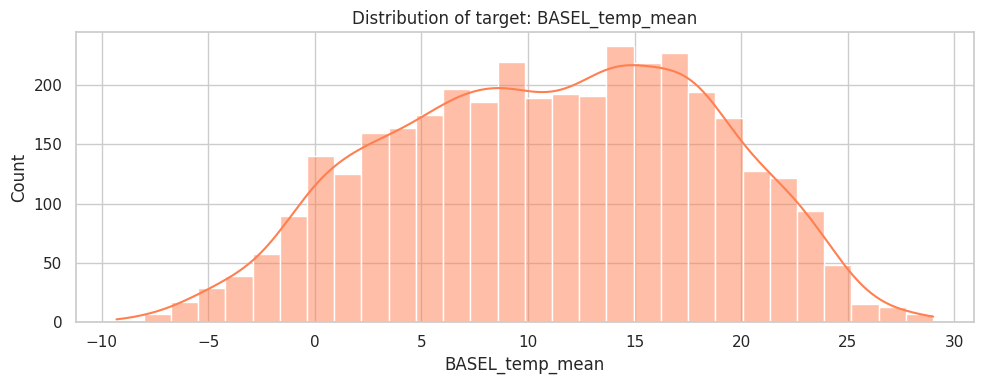

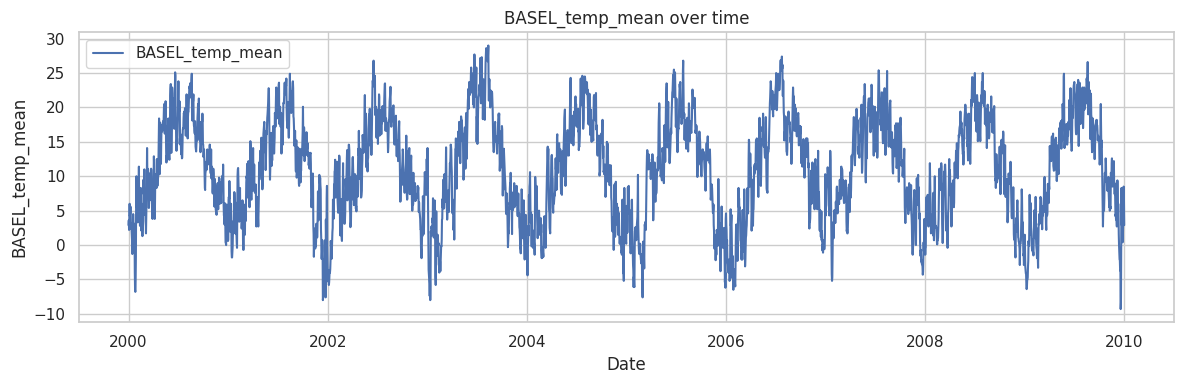

Target (t + 2 days of): BASEL_temp_mean
Train size: 2921, Test size: 731
Number of features: 164


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │        21,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,441 (115.00 KB)

 Trainable params: 29,441 (115.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1538 - mae: 0.8163 - val_loss: 0.2073 - val_mae: 0.3508
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2243 - mae: 0.3791 - val_loss: 0.1885 - val_mae: 0.3345
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1669 - mae: 0.3233 - val_loss: 0.1686 - val_mae: 0.3147
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1565 - mae: 0.3114 - val_loss: 0.1718 - val_mae: 0.3207
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1526 - mae: 0.3104 - val_loss: 0.1697 - val_mae: 0.3206
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1474 - mae: 0.3036 - val_loss: 0.1504 - val_mae: 0.2966
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1175 - mae: 0.2691 - val_loss: 0.1479 - val_mae: 0.3005
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1127 - mae: 0.2674 - val_loss: 0.1493 - val_mae: 0.3020
Epoch 9/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1206 - mae: 

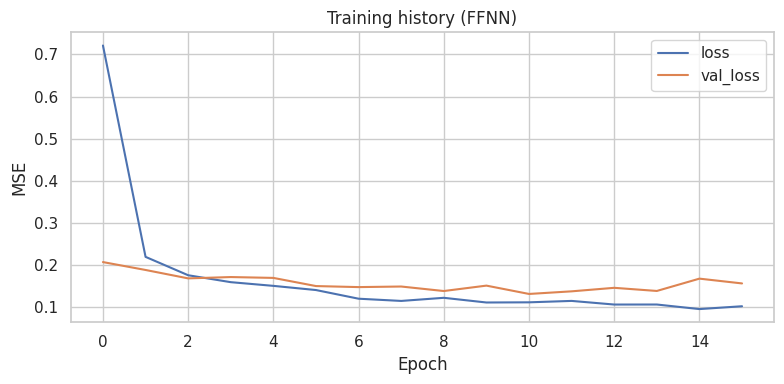

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Results for BASEL_temp_mean at t + 2 days:
  MAE  = 2.117
  RMSE = 2.732
  R^2  = 0.8620


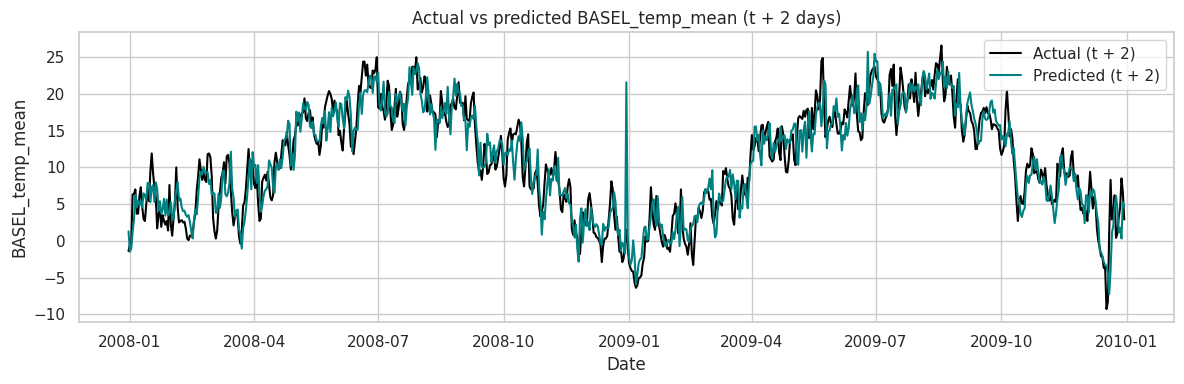

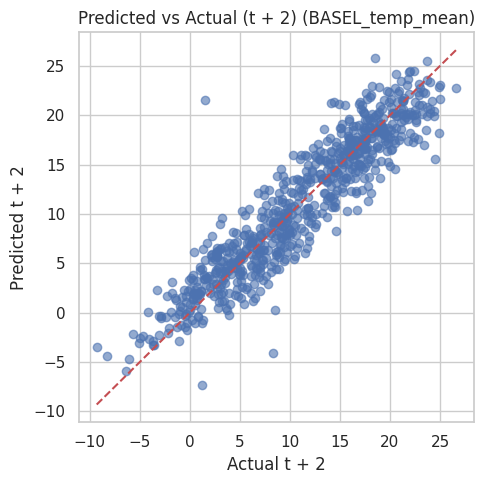

Running FFNN regression for ROMA_temp_mean at t + 2 days


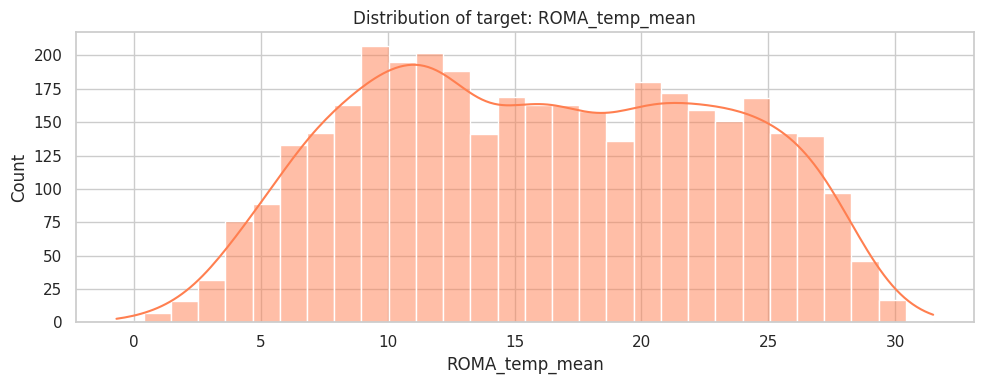

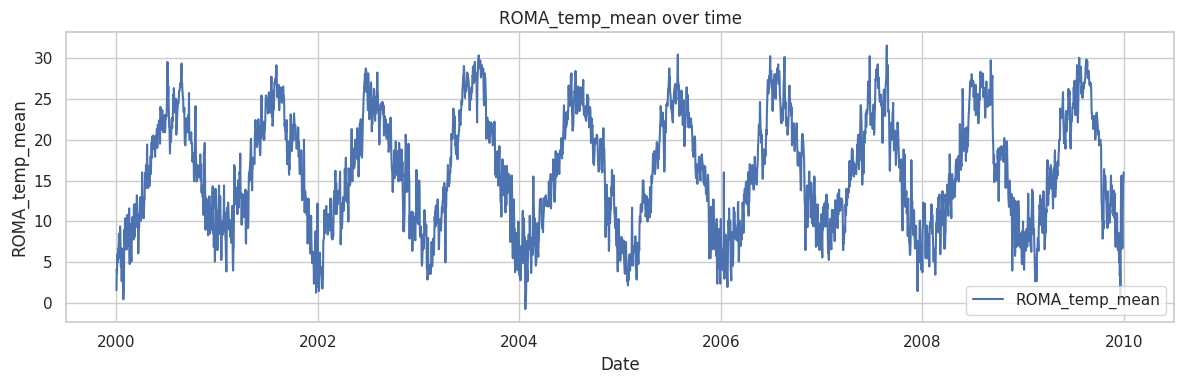

Target (t + 2 days of): ROMA_temp_mean
Train size: 2921, Test size: 731
Number of features: 164


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │        21,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,441 (115.00 KB)

 Trainable params: 29,441 (115.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9965 - mae: 0.7732 - val_loss: 0.1534 - val_mae: 0.3111
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1813 - mae: 0.3345 - val_loss: 0.1069 - val_mae: 0.2569
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1427 - mae: 0.2957 - val_loss: 0.0974 - val_mae: 0.2445
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1279 - mae: 0.2796 - val_loss: 0.1039 - val_mae: 0.2552
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1260 - mae: 0.2767 - val_loss: 0.1170 - val_mae: 0.2739
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1101 - mae: 0.2614 - val_loss: 0.1031 - val_mae: 0.2482
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1137 - mae: 0.2620 - val_loss: 0.1302 - val_mae: 0.2861
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0981 - mae: 0.2482 - val_loss: 0.0896 - val_mae: 0.2329
Epoch 9/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0914 - mae: 

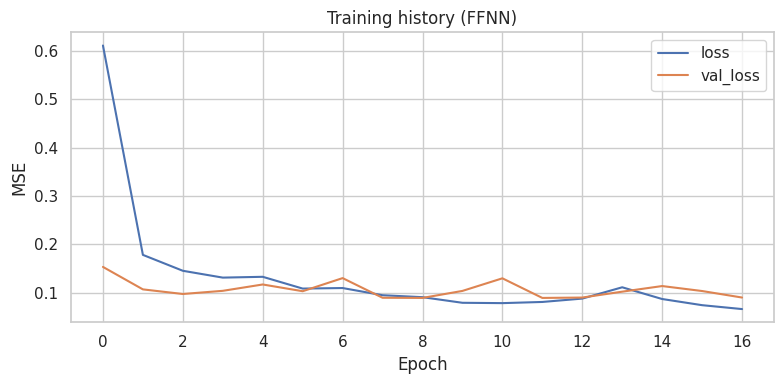

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Results for ROMA_temp_mean at t + 2 days:
  MAE  = 1.730
  RMSE = 2.203
  R^2  = 0.9022


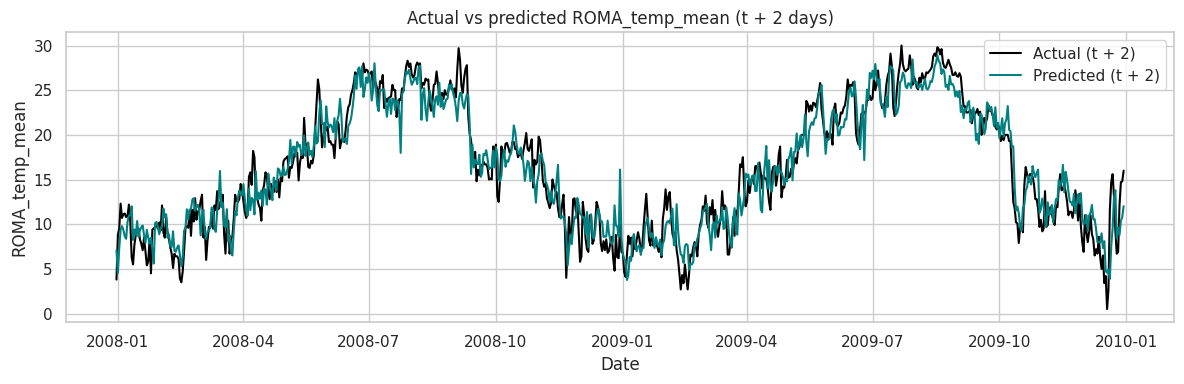

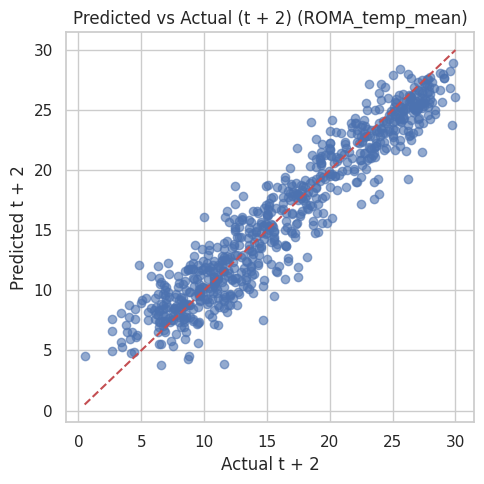

In [23]:
# 7-day ahead FFNN: Basel
results_basel_2 = run_ffnn_for_target_horizon(
    df,
    target_col="BASEL_temp_mean",
    horizon_days=2,
    date_col="DATE"
)

# 7-day ahead FFNN: Rome
results_roma_2 = run_ffnn_for_target_horizon(
    df,
    target_col="ROMA_temp_mean",
    horizon_days=2,
    date_col="DATE"
)